In [1]:
#!pip install xgboost

In [1]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [2]:
#!pip uninstall scikit-learn
#!pip install scikit-learn==1.2.2

In [61]:
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

from itertools import cycle
import matplotlib.pyplot as plt 

In [15]:
X_train = pd.read_csv('data/X_TRAINING_SET_Diabetes_ENCODED.csv')
X_test = pd.read_csv('data/X_VALIDATION_SET_ENCODED.csv')
y_train = pd.read_csv('data/Y_TRAINING_SET_EDIT.csv')
y_test = pd.read_csv('data/Y_VALIDATION_SET_EDIT.csv')

In [16]:
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])
X_train = X_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])

In [17]:
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_train.columns]
column_mapping = dict(zip(X_train.columns, new_column_names))
X_train = X_train.rename(columns=column_mapping)
#--------
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_test.columns]
column_mapping = dict(zip(X_test.columns, new_column_names))
X_test = X_test.rename(columns=column_mapping)


In [18]:
def results(model, X_train, y_train, X_test, y_test, r1,r2,r3):
    r1[type(model).__name__] = []
    r2[type(model).__name__] = []
    r3[type(model).__name__] = []
    model.fit(X_train, y_train)

    print(type(model).__name__)
   
    print("Acc:  ", model.score(X_test, y_test))

    y_pred = model.predict(X_test)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
        
    #class0
    fpr[0], tpr[0], _ = roc_curve(y_test_bin[:, 0], model.predict_proba(X_test)[:, 0])
    roc_auc[0] = auc(fpr[0], tpr[0])
    r1[type(model).__name__] = [fpr[0], tpr[0], roc_auc[0]]
    #class1
    fpr[1], tpr[1], _ = roc_curve(y_test_bin[:, 1], model.predict_proba(X_test)[:, 1])
    roc_auc[1] = auc(fpr[1], tpr[1])
    r2[type(model).__name__] = [fpr[1], tpr[1], roc_auc[1]]
    #class2
    fpr[2], tpr[2], _ = roc_curve(y_test_bin[:, 2], model.predict_proba(X_test)[:, 2])
    roc_auc[2] = auc(fpr[2], tpr[2])
    r3[type(model).__name__] = [fpr[2], tpr[2], roc_auc[2]]      

    prec = precision_score(y_test, y_pred, average=None)
    
    print("Prec: ", prec)

    sens = recall_score(y_test, y_pred, average=None)
    print("Sens: ", sens)

    f1 = f1_score(y_test, y_pred, average=None)
    print("F1: ", f1)

    print(classification_report(y_test, y_pred))


    res = {"Model_Name": type(model).__name__, "Accuracy": model.score(X_test, y_test),
           "Precision": prec, "Sensitivity": sens, "F1": f1, "ROC_AUC": roc_auc}



    return res

### Focusing only on XGBoost

In [10]:
roc_1 = {} 
roc_2 = {}
roc_3 = {}
model1 = XGBClassifier()
results(model1, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)

XGBClassifier
Acc:   0.6030375223347231
Prec:  [0.64575318 0.47115385 0.51743462]
Sens:  [0.80486905 0.04347826 0.47148936]
F1:  [0.71658456 0.07961007 0.49339469]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      5422
           1       0.47      0.04      0.08      1127
           2       0.52      0.47      0.49      3525

    accuracy                           0.60     10074
   macro avg       0.54      0.44      0.43     10074
weighted avg       0.58      0.60      0.57     10074



{'Model_Name': 'XGBClassifier',
 'Accuracy': 0.6030375223347231,
 'Precision': array([0.64575318, 0.47115385, 0.51743462]),
 'Sensitivity': array([0.80486905, 0.04347826, 0.47148936]),
 'F1': array([0.71658456, 0.07961007, 0.49339469]),
 'ROC_AUC': {0: 0.7316478469139296,
  1: 0.6777132991294788,
  2: 0.6945471183408435}}

In [18]:
def random_search_tuning():
    params = {
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    'n_estimators': [100, 250, 500, 750],
    'num_class': [3]
    }


    xgbclf = XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(X_train, y_train)

    best_combination = clf.best_params_

    return best_combination

if __name__ == '__main__':

    best_params = random_search_tuning()

    print("Best hyperparameter combination: ", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameter combination:  {'subsample': 0.8999999999999999, 'num_class': 3, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}


In [22]:
best_params


{'subsample': 0.8999999999999999,
 'num_class': 3,
 'n_estimators': 100,
 'max_depth': 6,
 'learning_rate': 0.2,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.7}

In [27]:
xgbclf = XGBClassifier(
    subsample=0.8999999999999999,
    num_class=3,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.2,
    colsample_bytree=0.7,
    colsample_bylevel=0.7
)

roc_1 = {} 
roc_2 = {}
roc_3 = {}
results(xgbclf, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)


XGBClassifier
Acc:   0.6055191582291046
Prec:  [0.64355569 0.53684211 0.52429668]
Sens:  [0.81316857 0.04525288 0.46524823]
F1:  [0.71848774 0.08346972 0.49301067]
              precision    recall  f1-score   support

           0       0.64      0.81      0.72      5422
           1       0.54      0.05      0.08      1127
           2       0.52      0.47      0.49      3525

    accuracy                           0.61     10074
   macro avg       0.57      0.44      0.43     10074
weighted avg       0.59      0.61      0.57     10074



{'Model_Name': 'XGBClassifier',
 'Accuracy': 0.6055191582291046,
 'Precision': array([0.64355569, 0.53684211, 0.52429668]),
 'Sensitivity': array([0.81316857, 0.04525288, 0.46524823]),
 'F1': array([0.71848774, 0.08346972, 0.49301067]),
 'ROC_AUC': {0: 0.7361349560546457,
  1: 0.6863369409265982,
  2: 0.7000593669760636}}

In [22]:
model1 = XGBClassifier()
model2 = RandomForestClassifier()
model3 = AdaBoostClassifier()
model4 = LinearDiscriminantAnalysis()

model_vc = VotingClassifier(estimators=[
    ('model1', model1),
    ('model2', model2),
    ('model3', model3),
    ('model4', model4)
], voting='soft')  

### Testing different method of grid search 


In [25]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [26]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [27]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  1%|▍                                              | 1/100 [00:02<03:54,  2.37s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  2%|▉                                              | 2/100 [00:04<03:53,  2.38s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  3%|█▍                                             | 3/100 [00:07<03:51,  2.39s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  4%|█▉                                             | 4/100 [00:09<03:49,  2.39s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  5%|██▎                                            | 5/100 [00:11<03:45,  2.37s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  6%|██▊                                            | 6/100 [00:14<03:45,  2.39s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  7%|███▎                                           | 7/100 [00:17<03:56,  2.54s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  8%|███▊                                           | 8/100 [00:20<04:22,  2.86s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
  9%|████▏                                          | 9/100 [00:23<04:07,  2.72s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 10%|████▌                                         | 10/100 [00:25<03:53,  2.59s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 11%|█████                                         | 11/100 [00:27<03:41,  2.49s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 12%|█████▌                                        | 12/100 [00:30<03:36,  2.46s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 13%|█████▉                                        | 13/100 [00:32<03:44,  2.58s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 14%|██████▍                                       | 14/100 [00:35<03:33,  2.49s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 15%|██████▉                                       | 15/100 [00:37<03:29,  2.46s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 16%|███████▎                                      | 16/100 [00:39<03:24,  2.43s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 17%|███████▊                                      | 17/100 [00:42<03:20,  2.42s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 18%|████████▎                                     | 18/100 [00:44<03:13,  2.35s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 19%|████████▋                                     | 19/100 [00:46<03:06,  2.30s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 20%|█████████▏                                    | 20/100 [00:48<03:02,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 21%|█████████▋                                    | 21/100 [00:51<02:59,  2.27s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 22%|██████████                                    | 22/100 [00:53<02:56,  2.26s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 23%|██████████▌                                   | 23/100 [00:55<02:54,  2.27s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 24%|███████████                                   | 24/100 [00:57<02:50,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 25%|███████████▌                                  | 25/100 [01:00<02:48,  2.24s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 26%|███████████▉                                  | 26/100 [01:02<02:46,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 27%|████████████▍                                 | 27/100 [01:04<02:42,  2.22s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 28%|████████████▉                                 | 28/100 [01:06<02:39,  2.22s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 29%|█████████████▎                                | 29/100 [01:09<02:39,  2.24s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 30%|█████████████▊                                | 30/100 [01:11<02:41,  2.31s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 31%|██████████████▎                               | 31/100 [01:13<02:37,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 32%|██████████████▋                               | 32/100 [01:16<02:33,  2.26s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 33%|███████████████▏                              | 33/100 [01:18<02:30,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 34%|███████████████▋                              | 34/100 [01:20<02:29,  2.26s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 35%|████████████████                              | 35/100 [01:22<02:30,  2.31s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 36%|████████████████▌                             | 36/100 [01:25<02:26,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 37%|█████████████████                             | 37/100 [01:27<02:21,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 38%|█████████████████▍                            | 38/100 [01:29<02:19,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 39%|█████████████████▉                            | 39/100 [01:31<02:16,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 40%|██████████████████▍                           | 40/100 [01:33<02:13,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 41%|██████████████████▊                           | 41/100 [01:36<02:11,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 42%|███████████████████▎                          | 42/100 [01:38<02:12,  2.29s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 43%|███████████████████▊                          | 43/100 [01:40<02:08,  2.26s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 44%|████████████████████▏                         | 44/100 [01:43<02:05,  2.24s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 45%|████████████████████▋                         | 45/100 [01:45<02:03,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 46%|█████████████████████▏                        | 46/100 [01:47<02:01,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 47%|█████████████████████▌                        | 47/100 [01:49<01:58,  2.24s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 48%|██████████████████████                        | 48/100 [01:51<01:56,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 49%|██████████████████████▌                       | 49/100 [01:54<01:52,  2.21s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 50%|███████████████████████                       | 50/100 [01:56<01:50,  2.21s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 51%|███████████████████████▍                      | 51/100 [01:58<01:48,  2.21s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 52%|███████████████████████▉                      | 52/100 [02:00<01:45,  2.21s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 53%|████████████████████████▍                     | 53/100 [02:03<01:44,  2.22s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 54%|████████████████████████▊                     | 54/100 [02:05<01:41,  2.21s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 55%|█████████████████████████▎                    | 55/100 [02:07<01:39,  2.22s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 56%|█████████████████████████▊                    | 56/100 [02:09<01:41,  2.30s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 57%|██████████████████████████▏                   | 57/100 [02:13<01:49,  2.54s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 58%|██████████████████████████▋                   | 58/100 [02:15<01:42,  2.43s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 59%|███████████████████████████▏                  | 59/100 [02:17<01:38,  2.40s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 60%|███████████████████████████▌                  | 60/100 [02:19<01:33,  2.34s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 61%|████████████████████████████                  | 61/100 [02:22<01:30,  2.32s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 62%|████████████████████████████▌                 | 62/100 [02:24<01:27,  2.30s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 63%|████████████████████████████▉                 | 63/100 [02:26<01:24,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 64%|█████████████████████████████▍                | 64/100 [02:28<01:22,  2.31s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 65%|█████████████████████████████▉                | 65/100 [02:31<01:23,  2.39s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 66%|██████████████████████████████▎               | 66/100 [02:33<01:19,  2.35s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 67%|██████████████████████████████▊               | 67/100 [02:36<01:17,  2.36s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 68%|███████████████████████████████▎              | 68/100 [02:38<01:15,  2.34s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 69%|███████████████████████████████▋              | 69/100 [02:40<01:12,  2.34s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 70%|████████████████████████████████▏             | 70/100 [02:42<01:09,  2.32s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 71%|████████████████████████████████▋             | 71/100 [02:45<01:06,  2.29s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 72%|█████████████████████████████████             | 72/100 [02:47<01:04,  2.31s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 73%|█████████████████████████████████▌            | 73/100 [02:49<01:02,  2.32s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 74%|██████████████████████████████████            | 74/100 [02:52<00:59,  2.30s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 75%|██████████████████████████████████▌           | 75/100 [02:54<00:57,  2.29s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 76%|██████████████████████████████████▉           | 76/100 [02:56<00:54,  2.29s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 77%|███████████████████████████████████▍          | 77/100 [02:58<00:52,  2.27s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 78%|███████████████████████████████████▉          | 78/100 [03:01<00:49,  2.27s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 79%|████████████████████████████████████▎         | 79/100 [03:03<00:47,  2.26s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 80%|████████████████████████████████████▊         | 80/100 [03:06<00:49,  2.50s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 81%|█████████████████████████████████████▎        | 81/100 [03:08<00:45,  2.40s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 82%|█████████████████████████████████████▋        | 82/100 [03:10<00:42,  2.36s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 83%|██████████████████████████████████████▏       | 83/100 [03:13<00:40,  2.36s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 84%|██████████████████████████████████████▋       | 84/100 [03:15<00:36,  2.31s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 85%|███████████████████████████████████████       | 85/100 [03:17<00:35,  2.36s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 86%|███████████████████████████████████████▌      | 86/100 [03:20<00:32,  2.29s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 87%|████████████████████████████████████████      | 87/100 [03:22<00:29,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 88%|████████████████████████████████████████▍     | 88/100 [03:24<00:27,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 89%|████████████████████████████████████████▉     | 89/100 [03:26<00:24,  2.27s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 90%|█████████████████████████████████████████▍    | 90/100 [03:29<00:22,  2.28s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 91%|█████████████████████████████████████████▊    | 91/100 [03:31<00:20,  2.27s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 92%|██████████████████████████████████████████▎   | 92/100 [03:33<00:18,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 93%|██████████████████████████████████████████▊   | 93/100 [03:35<00:15,  2.25s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 94%|███████████████████████████████████████████▏  | 94/100 [03:38<00:13,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 95%|███████████████████████████████████████████▋  | 95/100 [03:40<00:11,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 96%|████████████████████████████████████████████▏ | 96/100 [03:42<00:08,  2.24s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 97%|████████████████████████████████████████████▌ | 97/100 [03:44<00:06,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 98%|█████████████████████████████████████████████ | 98/100 [03:46<00:04,  2.23s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
 99%|█████████████████████████████████████████████▌| 99/100 [03:49<00:02,  2.22s/trial, best loss: -0.5382171927734762]

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\diyac\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                 
0.5382171927734762                                                                                                     
100%|█████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/trial, best loss: -0.5382171927734762]


In [28]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.745581303925575, 'gamma': 7.272718399957285, 'max_depth': 12.0, 'min_child_weight': 10.0, 'reg_alpha': 108.0, 'reg_lambda': 0.7304811835844915}


In [29]:
xgbclf = XGBClassifier(
    colsample_bytree=best_hyperparams['colsample_bytree'],
    gamma=best_hyperparams['gamma'],
    max_depth=int(best_hyperparams['max_depth']),
    min_child_weight=int(best_hyperparams['min_child_weight']),
    reg_alpha=best_hyperparams['reg_alpha'],
    reg_lambda=best_hyperparams['reg_lambda']
)

roc_1 = {} 
roc_2 = {}
roc_3 = {}
results(xgbclf, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)

XGBClassifier
Acc:   0.5937065713718483
Prec:  [0.62138145 1.         0.51587302]
Sens:  [0.85116193 0.00088731 0.38723404]
F1:  [0.71834384 0.00177305 0.44239183]
              precision    recall  f1-score   support

           0       0.62      0.85      0.72      5422
           1       1.00      0.00      0.00      1127
           2       0.52      0.39      0.44      3525

    accuracy                           0.59     10074
   macro avg       0.71      0.41      0.39     10074
weighted avg       0.63      0.59      0.54     10074



{'Model_Name': 'XGBClassifier',
 'Accuracy': 0.5937065713718483,
 'Precision': array([0.62138145, 1.        , 0.51587302]),
 'Sensitivity': array([0.85116193, 0.00088731, 0.38723404]),
 'F1': array([0.71834384, 0.00177305, 0.44239183]),
 'ROC_AUC': {0: 0.7136746711670836,
  1: 0.6611720365686962,
  2: 0.6749783465398322}}

### With the feature selection


In [39]:
X_train = pd.read_csv('data/CombinedBestFeatures.csv')
X_test = pd.read_csv('data/X_VALIDATION_SET_ENCODED.csv')
y_train = pd.read_csv('data/Y_TRAINING_SET_EDIT.csv')
y_test = pd.read_csv('data/Y_VALIDATION_SET_EDIT.csv')
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])
X_train = X_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_train.columns]
column_mapping = dict(zip(X_train.columns, new_column_names))
X_train = X_train.rename(columns=column_mapping)
#--------
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_test.columns]
column_mapping = dict(zip(X_test.columns, new_column_names))
X_test = X_test.rename(columns=column_mapping)

In [76]:
X_train = pd.read_csv('data/Xtr_Feature_Selected_xgb.csv')
X_test = pd.read_csv('data/X_VALIDATION_SET_ENCODED.csv')
y_train = pd.read_csv('data/Y_TRAINING_SET_EDIT.csv')
y_test = pd.read_csv('data/Y_VALIDATION_SET_EDIT.csv')
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])
X_train = X_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_train.columns]
column_mapping = dict(zip(X_train.columns, new_column_names))
X_train = X_train.rename(columns=column_mapping)
#--------
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_test.columns]
column_mapping = dict(zip(X_test.columns, new_column_names))
X_test = X_test.rename(columns=column_mapping)

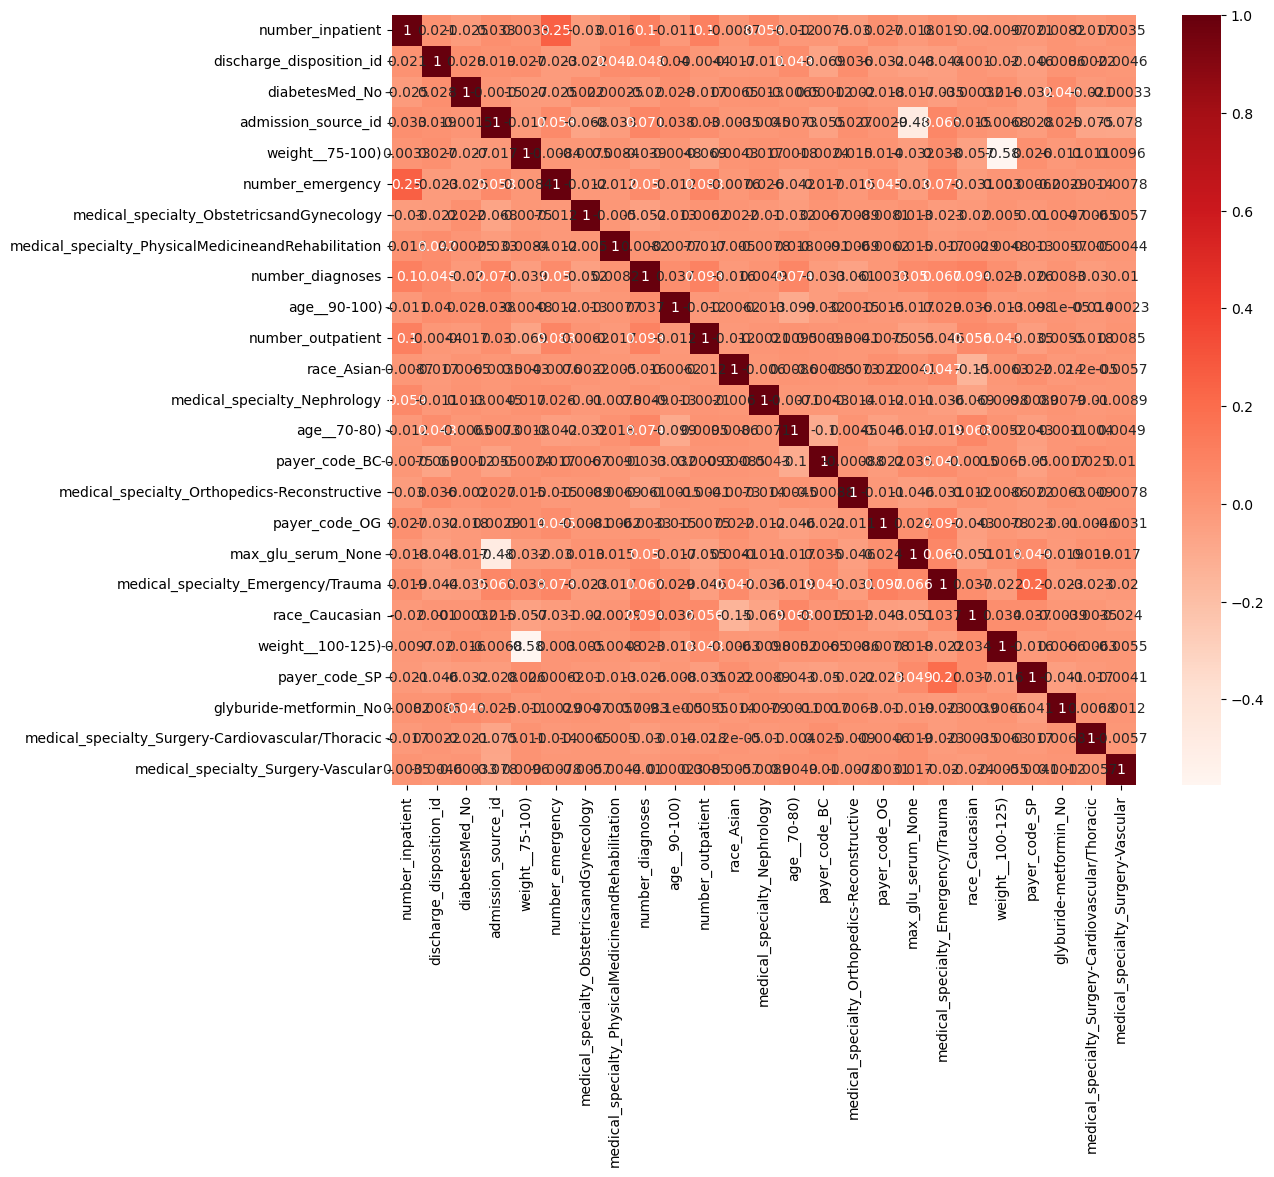

In [65]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()




In [72]:
threshold = 0.25 
high_correlation_features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if abs(cor.iloc[i, j]) > threshold:
            colname = cor.columns[i]
            high_correlation_features.add(colname)

print("Features with high correlation:", high_correlation_features)


Features with high correlation: {'number_emergency', 'weight__100-125)', 'max_glu_serum_None'}


In [77]:
common_columns = X_train.columns
X_test= X_test[common_columns]


In [80]:
def random_search_tuning():

    params = {
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    'n_estimators': [100, 250, 500, 750],
    'num_class': [3] 
    }


    xgbclf = XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(X_train, y_train)

    best_combination = clf.best_params_

    return best_combination

if __name__ == '__main__':

    best_params = random_search_tuning()

    print("Best hyperparameter combination: ", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameter combination:  {'subsample': 0.7999999999999999, 'num_class': 3, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5}


In [81]:
base_xgb = XGBClassifier()
roc_1 = {} 
roc_2 = {}
roc_3 = {}
results(base_xgb, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
best_xgb = XGBClassifier(
    subsample=0.7999999999999999,
    num_class=3,
    n_estimators=750,
    max_depth=3,
    learning_rate=0.1,
    colsample_bytree=0.6,
    colsample_bylevel=0.5
)

roc_1 = {}
roc_2 = {}
roc_3 = {}
results(best_xgb, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)


XGBClassifier
Acc:   0.5817947190788167
Prec:  [0.61302013 0.36538462 0.4984127 ]
Sens:  [0.84230911 0.03371783 0.35631206]
F1:  [0.70960224 0.06173842 0.41555004]
              precision    recall  f1-score   support

           0       0.61      0.84      0.71      5422
           1       0.37      0.03      0.06      1127
           2       0.50      0.36      0.42      3525

    accuracy                           0.58     10074
   macro avg       0.49      0.41      0.40     10074
weighted avg       0.55      0.58      0.53     10074

XGBClassifier
Acc:   0.5822910462576931
Prec:  [0.61167613 0.35443038 0.49793729]
Sens:  [0.85411287 0.02484472 0.34241135]
F1:  [0.71284538 0.04643449 0.40578248]
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      5422
           1       0.35      0.02      0.05      1127
           2       0.50      0.34      0.41      3525

    accuracy                           0.58     10074
   macro avg       

{'Model_Name': 'XGBClassifier',
 'Accuracy': 0.5822910462576931,
 'Precision': array([0.61167613, 0.35443038, 0.49793729]),
 'Sensitivity': array([0.85411287, 0.02484472, 0.34241135]),
 'F1': array([0.71284538, 0.04643449, 0.40578248]),
 'ROC_AUC': {0: 0.6930112479237323,
  1: 0.6797965520903986,
  2: 0.6516628709488428}}

# With the original data

In [23]:

roc_1 = {}
roc_2 = {}
roc_3 = {}

dict_models = {}
dict_models['XGBClassifier'] = results(model1, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
dict_models['RandomForestClassifier'] = results(model2, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
dict_models['AdaBoostClassifier'] = results(model3, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
dict_models['LinearDiscriminantAnalysis'] = results(model4, X_train, y_train, X_test.values, y_test, roc_1, roc_2, roc_3)
dict_models['VotingClassifier'] = results(model_vc, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
df = pd.DataFrame.from_dict(dict_models, orient='index')
df




XGBClassifier
Acc:   0.6030375223347231
Prec:  [0.64575318 0.47115385 0.51743462]
Sens:  [0.80486905 0.04347826 0.47148936]
F1:  [0.71658456 0.07961007 0.49339469]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      5422
           1       0.47      0.04      0.08      1127
           2       0.52      0.47      0.49      3525

    accuracy                           0.60     10074
   macro avg       0.54      0.44      0.43     10074
weighted avg       0.58      0.60      0.57     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier
Acc:   0.5987691085963868
Prec:  [0.62460911 0.47058824 0.52998501]
Sens:  [0.84728882 0.02129547 0.40113475]
F1:  [0.71910464 0.04074703 0.4566446 ]
              precision    recall  f1-score   support

           0       0.62      0.85      0.72      5422
           1       0.47      0.02      0.04      1127
           2       0.53      0.40      0.46      3525

    accuracy                           0.60     10074
   macro avg       0.54      0.42      0.41     10074
weighted avg       0.57      0.60      0.55     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier
Acc:   0.593607305936073
Prec:  [0.62034673 0.49122807 0.51863354]
Sens:  [0.85134637 0.02484472 0.37900709]
F1:  [0.71771748 0.0472973  0.43796099]
              precision    recall  f1-score   support

           0       0.62      0.85      0.72      5422
           1       0.49      0.02      0.05      1127
           2       0.52      0.38      0.44      3525

    accuracy                           0.59     10074
   macro avg       0.54      0.42      0.40     10074
weighted avg       0.57      0.59      0.54     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis
Acc:   0.5742505459598968
Prec:  [0.59342302 0.38518519 0.50706436]
Sens:  [0.87864257 0.0461402  0.27489362]
F1:  [0.70840149 0.08240887 0.35651214]
              precision    recall  f1-score   support

           0       0.59      0.88      0.71      5422
           1       0.39      0.05      0.08      1127
           2       0.51      0.27      0.36      3525

    accuracy                           0.57     10074
   macro avg       0.50      0.40      0.38     10074
weighted avg       0.54      0.57      0.52     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names

VotingClassifier
Acc:   0.6000595592614651
Prec:  [0.62458116 0.43076923 0.53257457]
Sens:  [0.85946145 0.02484472 0.38496454]
F1:  [0.72343398 0.04697987 0.4468961 ]
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      5422
           1       0.43      0.02      0.05      1127
           2       0.53      0.38      0.45      3525

    accuracy                           0.60     10074
   macro avg       0.53      0.42      0.41     10074
weighted avg       0.57      0.60      0.55     10074



,Model_Name,Accuracy,Precision,Sensitivity,F1,ROC_AUC
XGBClassifier,XGBClassifier,0.603038,"[0.6457531814146197, 0.47115384615384615, 0.51...","[0.8048690520103283, 0.043478260869565216, 0.4...","[0.716584564860427, 0.07961007311129165, 0.493...","{0: 0.7316478469139296, 1: 0.6777132991294788,..."
RandomForestClassifier,RandomForestClassifier,0.598769,"[0.6246091094493542, 0.47058823529411764, 0.52...","[0.8472888233124308, 0.02129547471162378, 0.40...","[0.7191046411520702, 0.040747028862478774, 0.4...","{0: 0.7151735921580592, 1: 0.628337496500391, ..."
AdaBoostClassifier,AdaBoostClassifier,0.593607,"[0.6203467275903777, 0.49122807017543857, 0.51...","[0.8513463666543711, 0.024844720496894408, 0.3...","[0.7177174842571717, 0.04729729729729729, 0.43...","{0: 0.7077148867722437, 1: 0.6658006941994704,..."
LinearDiscriminantAnalysis,LinearDiscriminantAnalysis,0.574251,"[0.593423019431988, 0.3851851851851852, 0.5070...","[0.8786425673183327, 0.04614019520851819, 0.27...","[0.7084014869888476, 0.08240887480190175, 0.35...","{0: 0.6768592368976682, 1: 0.6520482593492248,..."
VotingClassifier,VotingClassifier,0.600060,"[0.6245811553411071, 0.4307692307692308, 0.532...","[0.8594614533382515, 0.024844720496894408, 0.3...","[0.7234339827679889, 0.046979865771812075, 0.4...","{0: 0.7287161743199024, 1: 0.6715945989341354,..."


In [26]:
def disp_roc(roc_1,roc_2,roc_3):
    
    plt.figure(figsize=(15, 5))

    # Class 0 ROC curves
    plt.subplot(1, 3, 1)
    for model_name, values in roc_1.items():
        fpr, tpr, roc_auc = values
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Class 0')
    plt.legend()

    # Class 1 ROC curves
    plt.subplot(1, 3, 2)
    for model_name, values in roc_2.items():
        fpr, tpr, roc_auc = values
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Class 1')
    plt.legend()

    # Class 2 ROC curves
    plt.subplot(1, 3, 3)
    for model_name, values in roc_3.items():
        fpr, tpr, roc_auc = values
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Class 2')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
'''cols = ['Model_Name','Accuracy','Precision','Specificity', 'Sensitivity','F1'] 
resDF = pd.DataFrame(columns = cols)
print(resDF.head())
resDF = pd.concat(results(model1,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model2,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model3,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model4,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model5,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model6,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model7,X_train,y_train,X_test,y_test),ignore_index=True)
resDF.to_csv('data/testingClassifiers.csv')''' 

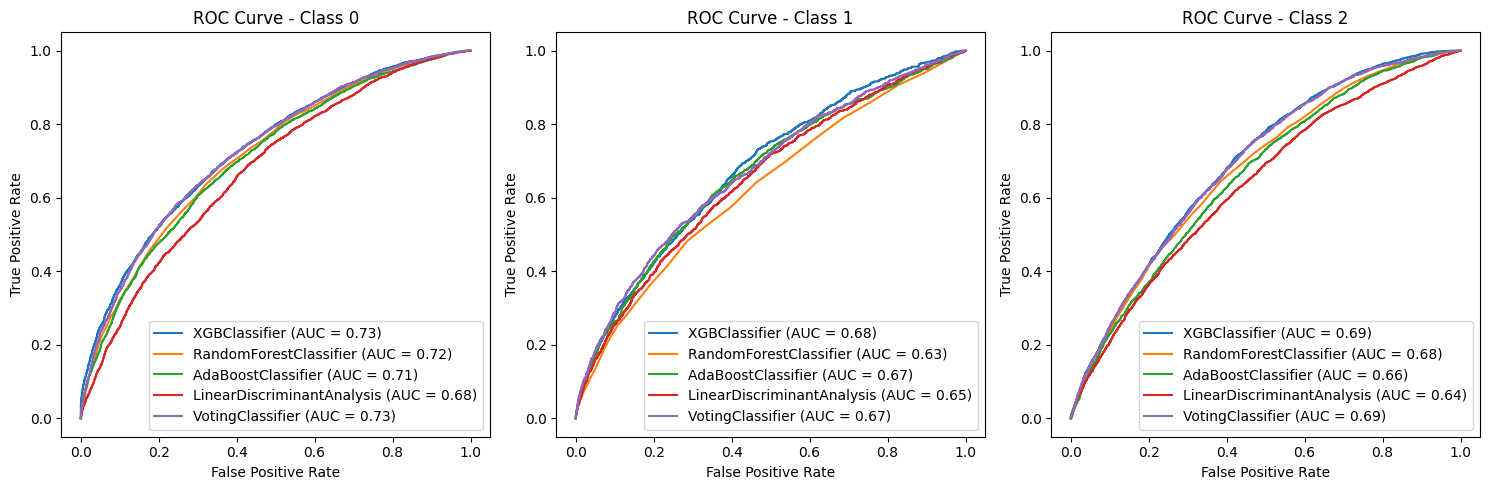

In [27]:
disp_roc(roc_1, roc_2, roc_3)

In [ ]:
#functi buildensemble(list_models, X, Y): 
 #loop xi through each row of x  
    #for k in 1 to len of list_models
        # model = model1 
        #predk = model.predict(xi, avg=none)
    #row vector of 9 things add Y to the end    
    #return 

In [ ]:
#def specificity(ytest,ypred):
#    tn, fp, fn, tp = confusion_matrix(ytest,ypred).ravel()
#    spec = tn/(tn+fp)
#    return spec

# With SMOTEEN

check the class distribution to see how imbalanced the data is
check if the classes are overlapping 

In [9]:
y_train.value_counts()

readmitted
0             38439
2             24875
1              7922
Name: count, dtype: int64

Class labels and their meanings

* 0 = NO 
* <30 = 1
* >20 = 2


In [11]:
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
X_tr_bal, y_tr_bal = sme.fit_resample(X_train, y_train)


In [12]:
y_tr_bal.value_counts()

readmitted
1             13615
2              8320
0              6189
Name: count, dtype: int64

In [25]:
roc_1b = {} 
roc_2b = {}
roc_3b = {}

dict_models2 = {}
dict_models2['XGBClassifier'] = results(model1, X_tr_bal, y_tr_bal, X_test, y_test, roc_1b, roc_2b, roc_3b)
dict_models2['RandomForestClassifier'] = results(model2, X_tr_bal, y_tr_bal, X_test, y_test, roc_1b, roc_2b, roc_3b)
dict_models2['AdaBoostClassifier'] = results(model3, X_tr_bal, y_tr_bal, X_test, y_test, roc_1b, roc_2b, roc_3b)
dict_models2['LinearDiscriminantAnalysis'] = results(model4, X_tr_bal, y_tr_bal, X_test.values, y_test, roc_1b, roc_2b, roc_3b)
dict_models2['VotingClassifier'] = results(model_vc, X_tr_bal, y_tr_bal, X_test, y_test, roc_1b, roc_2b, roc_3b)
df2 = pd.DataFrame.from_dict(dict_models2, orient='index')
df2


XGBClassifier
Acc:   0.5318642048838594
Prec:  [0.6913474  0.21814255 0.45630106]
Sens:  [0.59240133 0.26885537 0.52283688]
F1:  [0.63806118 0.24085851 0.4873083 ]
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      5422
           1       0.22      0.27      0.24      1127
           2       0.46      0.52      0.49      3525

    accuracy                           0.53     10074
   macro avg       0.46      0.46      0.46     10074
weighted avg       0.56      0.53      0.54     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier
Acc:   0.5220369267421084
Prec:  [0.66606786 0.19777932 0.4518355 ]
Sens:  [0.61545555 0.25288376 0.46439716]
F1:  [0.63976227 0.22196262 0.45803022]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      5422
           1       0.20      0.25      0.22      1127
           2       0.45      0.46      0.46      3525

    accuracy                           0.52     10074
   macro avg       0.44      0.44      0.44     10074
weighted avg       0.54      0.52      0.53     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier
Acc:   0.5123089140361327
Prec:  [0.67346044 0.19518221 0.45529291]
Sens:  [0.56676503 0.28039042 0.50269504]
F1:  [0.61552328 0.23015295 0.47782122]
              precision    recall  f1-score   support

           0       0.67      0.57      0.62      5422
           1       0.20      0.28      0.23      1127
           2       0.46      0.50      0.48      3525

    accuracy                           0.51     10074
   macro avg       0.44      0.45      0.44     10074
weighted avg       0.54      0.51      0.52     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis
Acc:   0.5299781616041295
Prec:  [0.62923383 0.23383085 0.44731929]
Sens:  [0.64072298 0.16681455 0.47574468]
F1:  [0.63492644 0.19471776 0.46109431]
              precision    recall  f1-score   support

           0       0.63      0.64      0.63      5422
           1       0.23      0.17      0.19      1127
           2       0.45      0.48      0.46      3525

    accuracy                           0.53     10074
   macro avg       0.44      0.43      0.43     10074
weighted avg       0.52      0.53      0.52     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names

VotingClassifier
Acc:   0.5568790946992257
Prec:  [0.67107251 0.25212766 0.47394476]
Sens:  [0.65547768 0.21029281 0.51602837]
F1:  [0.66318343 0.22931785 0.49409208]
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      5422
           1       0.25      0.21      0.23      1127
           2       0.47      0.52      0.49      3525

    accuracy                           0.56     10074
   macro avg       0.47      0.46      0.46     10074
weighted avg       0.56      0.56      0.56     10074



,Model_Name,Accuracy,Precision,Sensitivity,F1,ROC_AUC
XGBClassifier,XGBClassifier,0.531864,"[0.6913473956091262, 0.21814254859611232, 0.45...","[0.5924013279232755, 0.2688553682342502, 0.522...","[0.6380611839491458, 0.24085850556438793, 0.48...","{0: 0.6993840458588351, 1: 0.6465028355387524,..."
RandomForestClassifier,RandomForestClassifier,0.522037,"[0.666067864271457, 0.19777931991672448, 0.451...","[0.6154555514570269, 0.2528837622005324, 0.464...","[0.6397622699386503, 0.2219626168224299, 0.458...","{0: 0.6845497135487948, 1: 0.6381873279389848,..."
AdaBoostClassifier,AdaBoostClassifier,0.512309,"[0.673460442691212, 0.19518221124150711, 0.455...","[0.566765031353744, 0.2803904170363798, 0.5026...","[0.6155232849273912, 0.23015294974508374, 0.47...","{0: 0.6706262312105105, 1: 0.6459661048415946,..."
LinearDiscriminantAnalysis,LinearDiscriminantAnalysis,0.529978,"[0.6292338344502807, 0.23383084577114427, 0.44...","[0.6407229804500184, 0.1668145519077196, 0.475...","[0.6349264369916842, 0.19471776281719316, 0.46...","{0: 0.640752556461637, 1: 0.6192842817145908, ..."
VotingClassifier,VotingClassifier,0.556879,"[0.6710725075528701, 0.2521276595744681, 0.473...","[0.6554776835116193, 0.21029281277728482, 0.51...","[0.6631834297443553, 0.22931785195936139, 0.49...","{0: 0.6980559600341655, 1: 0.6587786163396019,..."


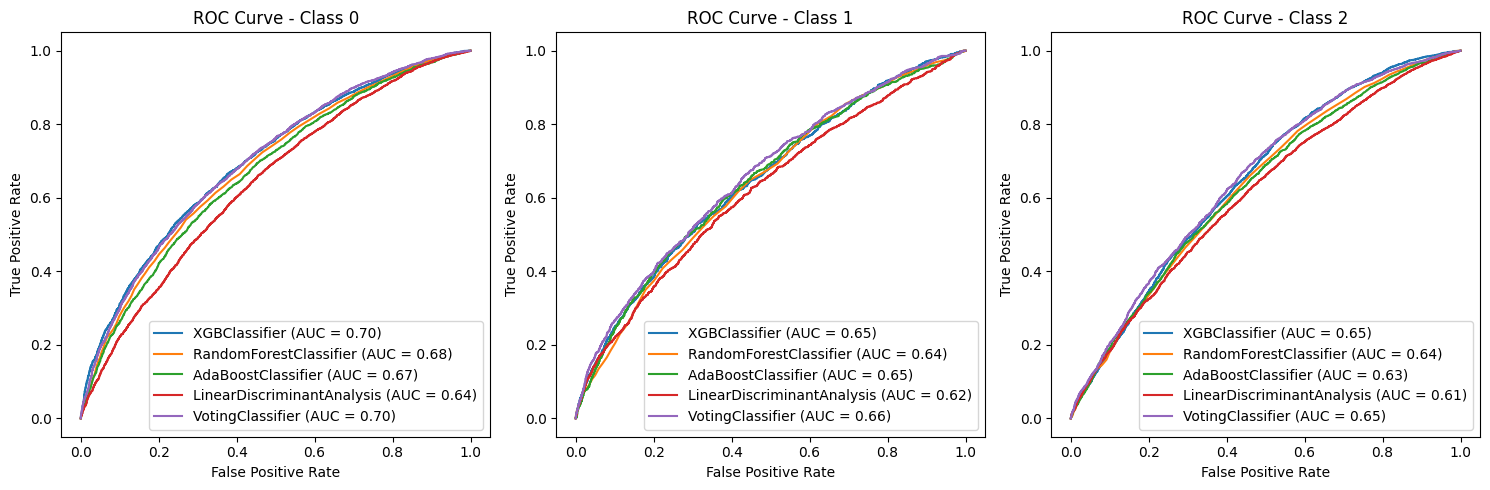

In [28]:
disp_roc(roc_1b, roc_2b, roc_3b)

In [15]:
df2.to_csv("With-SMOTEEN.csv")

In [19]:
df.to_csv("Original-data.csv")

Key observations from the results without class imbalance fix: 
* Classifying readmission = NO has good performance despite having lesser number of instances
* Class 1, i.e readmissions < 30 days has the worst performance despite having the highest number of instances
* Class 2, i.e, readmissions > 30 days has better performance

After fixing the class imbalance:
* the performance of class 1 improves manyfolds 


# With SMOTE

In [29]:
from imblearn.over_sampling import SMOTE
sme = SMOTE(random_state=42)
X_tr_bal2, y_tr_bal2 = sme.fit_resample(X_train, y_train)

roc_1c = {} 
roc_2c = {}
roc_3c = {}

dict_models3 = {}
dict_models3['XGBClassifier'] = results(model1, X_tr_bal2, y_tr_bal2, X_test, y_test, roc_1c, roc_2c, roc_3c)
dict_models3['RandomForestClassifier'] = results(model2, X_tr_bal2, y_tr_bal2, X_test, y_test, roc_1c, roc_2c, roc_3c)
dict_models3['AdaBoostClassifier'] = results(model3, X_tr_bal2, y_tr_bal2, X_test, y_test, roc_1c, roc_2c, roc_3c)
dict_models3['LinearDiscriminantAnalysis'] = results(model4, X_tr_bal2, y_tr_bal2, X_test.values, y_test, roc_1c, roc_2c, roc_3c)
dict_models3['VotingClassifier'] = results(model_vc, X_tr_bal2, y_tr_bal2, X_test, y_test, roc_1c, roc_2c, roc_3c)
df3 = pd.DataFrame.from_dict(dict_models3, orient='index')
df3


XGBClassifier
Acc:   0.6048243001786778
Prec:  [0.64599941 0.44099379 0.52437082]
Sens:  [0.80708226 0.06299911 0.46695035]
F1:  [0.71761233 0.11024845 0.4939976 ]
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      5422
           1       0.44      0.06      0.11      1127
           2       0.52      0.47      0.49      3525

    accuracy                           0.60     10074
   macro avg       0.54      0.45      0.44     10074
weighted avg       0.58      0.60      0.57     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier
Acc:   0.5849712130236252
Prec:  [0.62105706 0.35454545 0.50300247]
Sens:  [0.81704168 0.03460515 0.40397163]
F1:  [0.70569494 0.06305578 0.44808055]
              precision    recall  f1-score   support

           0       0.62      0.82      0.71      5422
           1       0.35      0.03      0.06      1127
           2       0.50      0.40      0.45      3525

    accuracy                           0.58     10074
   macro avg       0.49      0.42      0.41     10074
weighted avg       0.55      0.58      0.54     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier
Acc:   0.568294619813381
Prec:  [0.61964181 0.25       0.47053171]
Sens:  [0.77849502 0.0310559  0.41673759]
F1:  [0.69004414 0.05524862 0.44200391]
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      5422
           1       0.25      0.03      0.06      1127
           2       0.47      0.42      0.44      3525

    accuracy                           0.57     10074
   macro avg       0.45      0.41      0.40     10074
weighted avg       0.53      0.57      0.53     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis
Acc:   0.5715703791939647
Prec:  [0.60640763 0.34920635 0.4813154 ]
Sens:  [0.82036149 0.01952085 0.36539007]
F1:  [0.69734264 0.03697479 0.41541687]
              precision    recall  f1-score   support

           0       0.61      0.82      0.70      5422
           1       0.35      0.02      0.04      1127
           2       0.48      0.37      0.42      3525

    accuracy                           0.57     10074
   macro avg       0.48      0.40      0.38     10074
weighted avg       0.53      0.57      0.52     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names

VotingClassifier
Acc:   0.5997617629541394
Prec:  [0.62884193 0.45901639 0.52513761]
Sens:  [0.84526005 0.02484472 0.40595745]
F1:  [0.72116444 0.04713805 0.45792   ]
              precision    recall  f1-score   support

           0       0.63      0.85      0.72      5422
           1       0.46      0.02      0.05      1127
           2       0.53      0.41      0.46      3525

    accuracy                           0.60     10074
   macro avg       0.54      0.43      0.41     10074
weighted avg       0.57      0.60      0.55     10074



,Model_Name,Accuracy,Precision,Sensitivity,F1,ROC_AUC
XGBClassifier,XGBClassifier,0.604824,"[0.6459994095069382, 0.4409937888198758, 0.524...","[0.8070822574695684, 0.06299911268855368, 0.46...","[0.7176123319121024, 0.11024844720496894, 0.49...","{0: 0.7325473779160917, 1: 0.6791893085466628,..."
RandomForestClassifier,RandomForestClassifier,0.584971,"[0.6210570587410627, 0.35454545454545455, 0.50...","[0.817041682036149, 0.03460514640638864, 0.403...","[0.705694942254082, 0.06305578011317704, 0.448...","{0: 0.6942420025037322, 1: 0.630982472053458, ..."
AdaBoostClassifier,AdaBoostClassifier,0.568295,"[0.6196418085731062, 0.25, 0.47053171044202435]","[0.7784950202877167, 0.031055900621118012, 0.4...","[0.6900441392839627, 0.055248618784530384, 0.4...","{0: 0.6453094427879411, 1: 0.6397512552724717,..."
LinearDiscriminantAnalysis,LinearDiscriminantAnalysis,0.571570,"[0.6064076346284936, 0.3492063492063492, 0.481...","[0.8203614902250093, 0.019520851818988466, 0.3...","[0.6973426354158502, 0.036974789915966394, 0.4...","{0: 0.6642796393661313, 1: 0.6375973902907877,..."
VotingClassifier,VotingClassifier,0.599762,"[0.6288419319429198, 0.45901639344262296, 0.52...","[0.8452600516414607, 0.024844720496894408, 0.4...","[0.721164437450826, 0.04713804713804713, 0.457...","{0: 0.7228245614424594, 1: 0.6693500887460209,..."


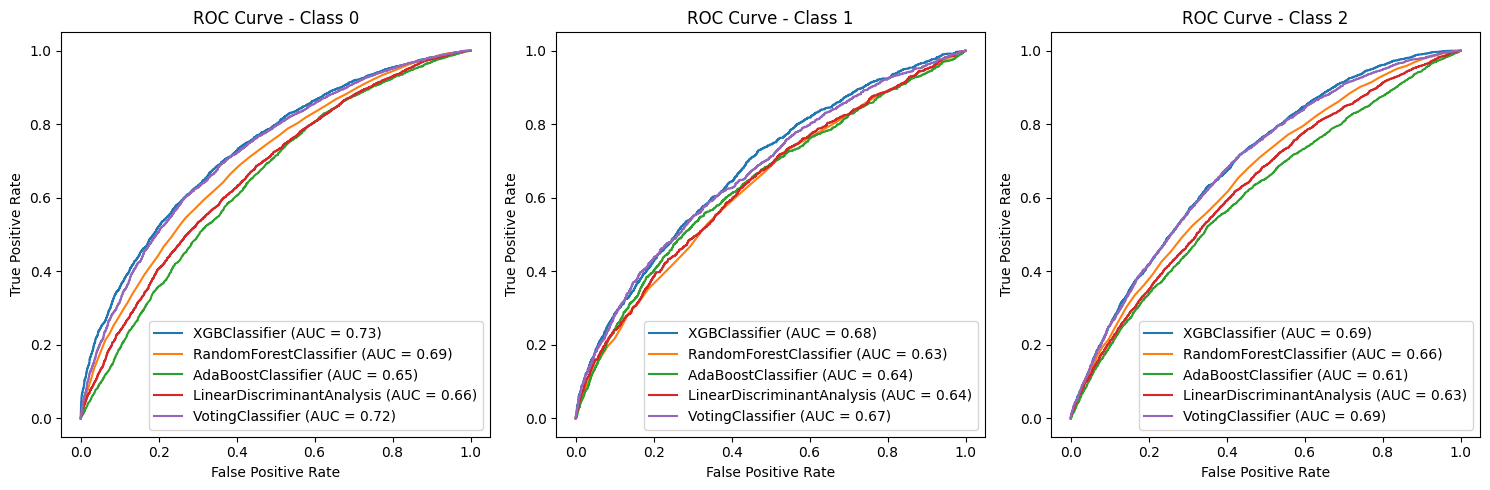

In [31]:
disp_roc(roc_1c, roc_2c, roc_3c)
df3.to_csv("With-SMOTE.csv")

* SMOTE doesnt really improve the performance but SMOTEEN does. 
* This could mean that a bit of undersampling is required. 

Lets try undersampling 1,2 classes and see what happens

# Trying undersampling techniques  - ENN

Edited Nearest Neighbours works by removing samples close to the decision boundary

In [33]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_tr_bal3, y_tr_bal3 = enn.fit_resample(X_train, y_train)


roc_1d = {}
roc_2d = {}
roc_3d = {}

dict_models3 = {}
dict_models3['XGBClassifier'] = results(model1, X_tr_bal3, y_tr_bal3, X_test, y_test, roc_1d, roc_2d, roc_3d)
dict_models3['RandomForestClassifier'] = results(model2, X_tr_bal3, y_tr_bal3, X_test, y_test,  roc_1d, roc_2d, roc_3d)
dict_models3['AdaBoostClassifier'] = results(model3, X_tr_bal3, y_tr_bal3, X_test, y_test,  roc_1d, roc_2d, roc_3d)
dict_models3['LinearDiscriminantAnalysis'] = results(model4, X_tr_bal3, y_tr_bal3, X_test.values, y_test,  roc_1d, roc_2d, roc_3d)
dict_models3['VotingClassifier'] = results(model_vc, X_tr_bal3, y_tr_bal3, X_test, y_test,  roc_1d, roc_2d, roc_3d)
df4 = pd.DataFrame.from_dict(dict_models3, orient='index')
df4

XGBClassifier
Acc:   0.401131625967838
Prec:  [0.70123735 0.14528478 0.53284672]
Sens:  [0.57488012 0.69032831 0.04141844]
F1:  [0.63180298 0.24004937 0.07686233]
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      5422
           1       0.15      0.69      0.24      1127
           2       0.53      0.04      0.08      3525

    accuracy                           0.40     10074
   macro avg       0.46      0.44      0.32     10074
weighted avg       0.58      0.40      0.39     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier
Acc:   0.4100655151876117
Prec:  [0.6862344  0.1482772  0.52631579]
Sens:  [0.61877536 0.67968057 0.00283688]
F1:  [0.65076132 0.2434451  0.00564334]
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      5422
           1       0.15      0.68      0.24      1127
           2       0.53      0.00      0.01      3525

    accuracy                           0.41     10074
   macro avg       0.45      0.43      0.30     10074
weighted avg       0.57      0.41      0.38     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier
Acc:   0.3984514592019059
Prec:  [0.68092314 0.14453718 0.4556962 ]
Sens:  [0.59313906 0.67613132 0.01021277]
F1:  [0.6340069  0.23816221 0.0199778 ]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      5422
           1       0.14      0.68      0.24      1127
           2       0.46      0.01      0.02      3525

    accuracy                           0.40     10074
   macro avg       0.43      0.43      0.30     10074
weighted avg       0.54      0.40      0.37     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis
Acc:   0.4220766329164185
Prec:  [0.64452622 0.15102672 0.59090909]
Sens:  [0.64607156 0.60692103 0.01843972]
F1:  [0.64529796 0.24186704 0.03576341]


C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names

              precision    recall  f1-score   support

           0       0.64      0.65      0.65      5422
           1       0.15      0.61      0.24      1127
           2       0.59      0.02      0.04      3525

    accuracy                           0.42     10074
   macro avg       0.46      0.42      0.31     10074
weighted avg       0.57      0.42      0.39     10074



C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Priya Velu\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier
Acc:   0.41681556482032955
Prec:  [0.68964816 0.15217816 0.76315789]
Sens:  [0.62541498 0.69121562 0.00822695]
F1:  [0.65596286 0.24943964 0.01627842]
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      5422
           1       0.15      0.69      0.25      1127
           2       0.76      0.01      0.02      3525

    accuracy                           0.42     10074
   macro avg       0.53      0.44      0.31     10074
weighted avg       0.66      0.42      0.39     10074



,Model_Name,Accuracy,Precision,Sensitivity,F1,ROC_AUC
XGBClassifier,XGBClassifier,0.401132,"[0.7012373453318336, 0.14528478057889824, 0.53...","[0.5748801180376245, 0.6903283052351376, 0.041...","[0.6318029796290666, 0.2400493674791731, 0.076...","{0: 0.7099737249250133, 1: 0.6570273985549726,..."
RandomForestClassifier,RandomForestClassifier,0.410066,"[0.6862344037635508, 0.14827719705768486, 0.52...","[0.6187753596458871, 0.6796805678793256, 0.002...","[0.6507613228590825, 0.24344509772763387, 0.00...","{0: 0.6970572542423736, 1: 0.6435526018397407,..."
AdaBoostClassifier,AdaBoostClassifier,0.398451,"[0.6809231420707178, 0.1445371775417299, 0.455...","[0.5931390630763556, 0.676131322094055, 0.0102...","[0.6340068999507146, 0.23816221284575714, 0.01...","{0: 0.6806739278814727, 1: 0.6342459474204248,..."
LinearDiscriminantAnalysis,LinearDiscriminantAnalysis,0.422077,"[0.644526218951242, 0.15102671671450651, 0.590...","[0.6460715603098488, 0.6069210292812778, 0.018...","[0.6452979644469006, 0.24186704384724186, 0.03...","{0: 0.6584571693362254, 1: 0.637646779035648, ..."
VotingClassifier,VotingClassifier,0.416816,"[0.6896481594468171, 0.15217815979683533, 0.76...","[0.6254149760236075, 0.6912156166814551, 0.008...","[0.6559628590772802, 0.2494396413704771, 0.016...","{0: 0.7088180997579049, 1: 0.6640268151132337,..."


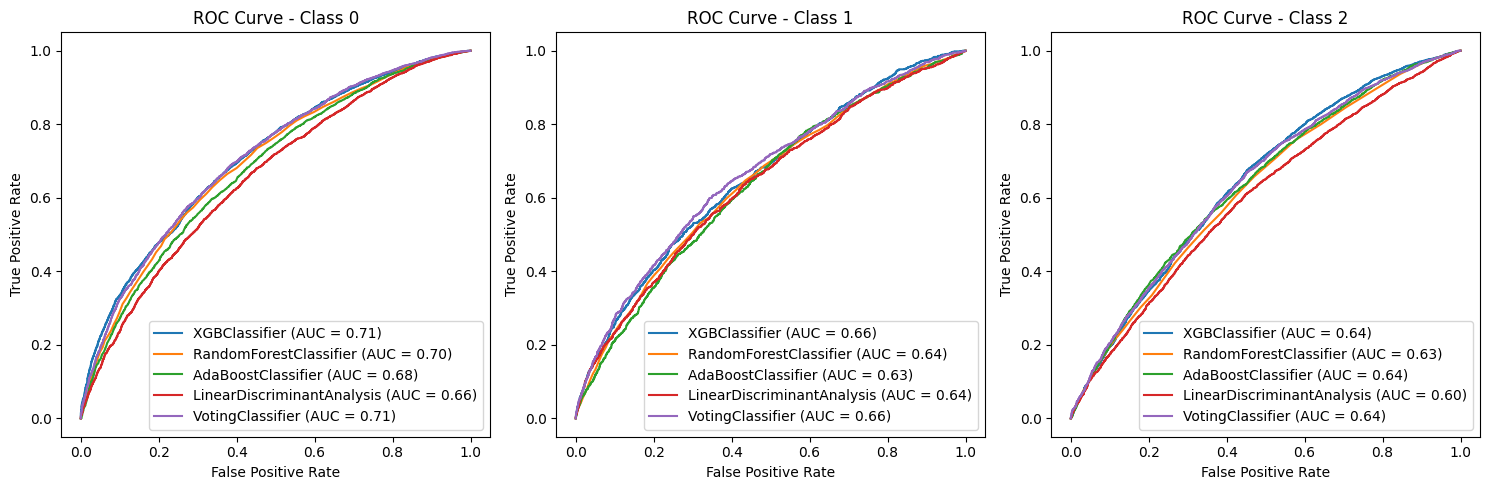

In [34]:
disp_roc(roc_1d, roc_2d, roc_3d)
df4.to_csv("With-ENN.csv")

* undersampling has greatly improved the class 1 classification rates but class 2 has taken a hit now. The overall performance has gone down even further. 

In [42]:
print("orginal:",end=" ")
print(y_train.value_counts()) # original dataset
print("ENN: ",end=" ")
print(y_tr_bal3.value_counts()) # ENN
print("SMOTE:",end=" ")
print(y_tr_bal2.value_counts()) #SMOTE
print("SMOTEEN:",end=" ")
print(y_tr_bal.value_counts()) # SMOTE-ENN


orginal: readmitted
0             38439
2             24875
1              7922
Name: count, dtype: int64
ENN:  readmitted
0             8495
1             7922
2             1661
Name: count, dtype: int64
SMOTE: readmitted
0             8495
1             7922
2             1661
Name: count, dtype: int64
SMOTEEN: readmitted
1             13615
2              8320
0              6189
Name: count, dtype: int64


In [27]:
Ytr = pd.read_csv("C:/Users/diyac/ML_Diabetes_Project/data/Y_TRAINING_SET.csv")


In [28]:
Ytr['readmitted'] = Ytr['readmitted'].map({'NO': 0, '<30': 1, '>30': 2})


In [29]:
Ytr = Ytr.drop(columns=['Unnamed: 0'])

In [30]:
Ytr.to_csv("C:/Users/diyac/ML_Diabetes_Project/data/Y_TRAINING_SET_EDIT.csv")